In [ ]:
from google.colab import files

uploaded = files.upload()

Saving DCGAN.zip to DCGAN.zip


In [ ]:
import zipfile
import os

In [ ]:
with zipfile.ZipFile("/content/DCGAN.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
input_folder='/content/data_faces'

In [ ]:
splitfolders.ratio(input_folder, output='/content/data', seed=42, 
                   ratio=(.6,.2, .2), group_prefix=None)

Copying files: 1289 files [00:00, 5527.94 files/s]


In [ ]:
splitfolders.fixed(input_folder, output='/content/data', seed=42, 
                   fixed=(35, 20), oversample=False, group_prefix=None)

Copying files: 1289 files [00:00, 4226.63 files/s]


In [ ]:
import numpy as np
from collections import OrderedDict
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from functools import reduce
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
%config InlineBackend.figure_format = 'retina'
train_on_gpu = torch.cuda.is_available()

In [ ]:
def DataConstructor2000(path_to_train, path_to_test, classes=None, num_workers=4, batch_size=32, valid_size = 0.2):
    
  
    # Transformations to the image, edit as need be
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize([32,32]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(path_to_train, transform=transform)
    print("Successfully Loaded Training Set.")

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    print("Successfully Loaded Test Set.")

    
    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, 
        num_workers=num_workers, shuffle=True)
    if classes != None:
        print("Number of Classes:", len(classes))
    return train_loader, valid_loader, test_loader, classes

In [ ]:
train_loader, valid_loader,test_loader, classes = DataConstructor2000(path_to_train='/content/data/train',path_to_test='/content/data/test',
                                                                       classes=['Fake','Real'],num_workers=40, batch_size=150, valid_size = 0.3)

Successfully Loaded Training Set.
Successfully Loaded Test Set.
Number of Classes: 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(150, 3, 32, 32)


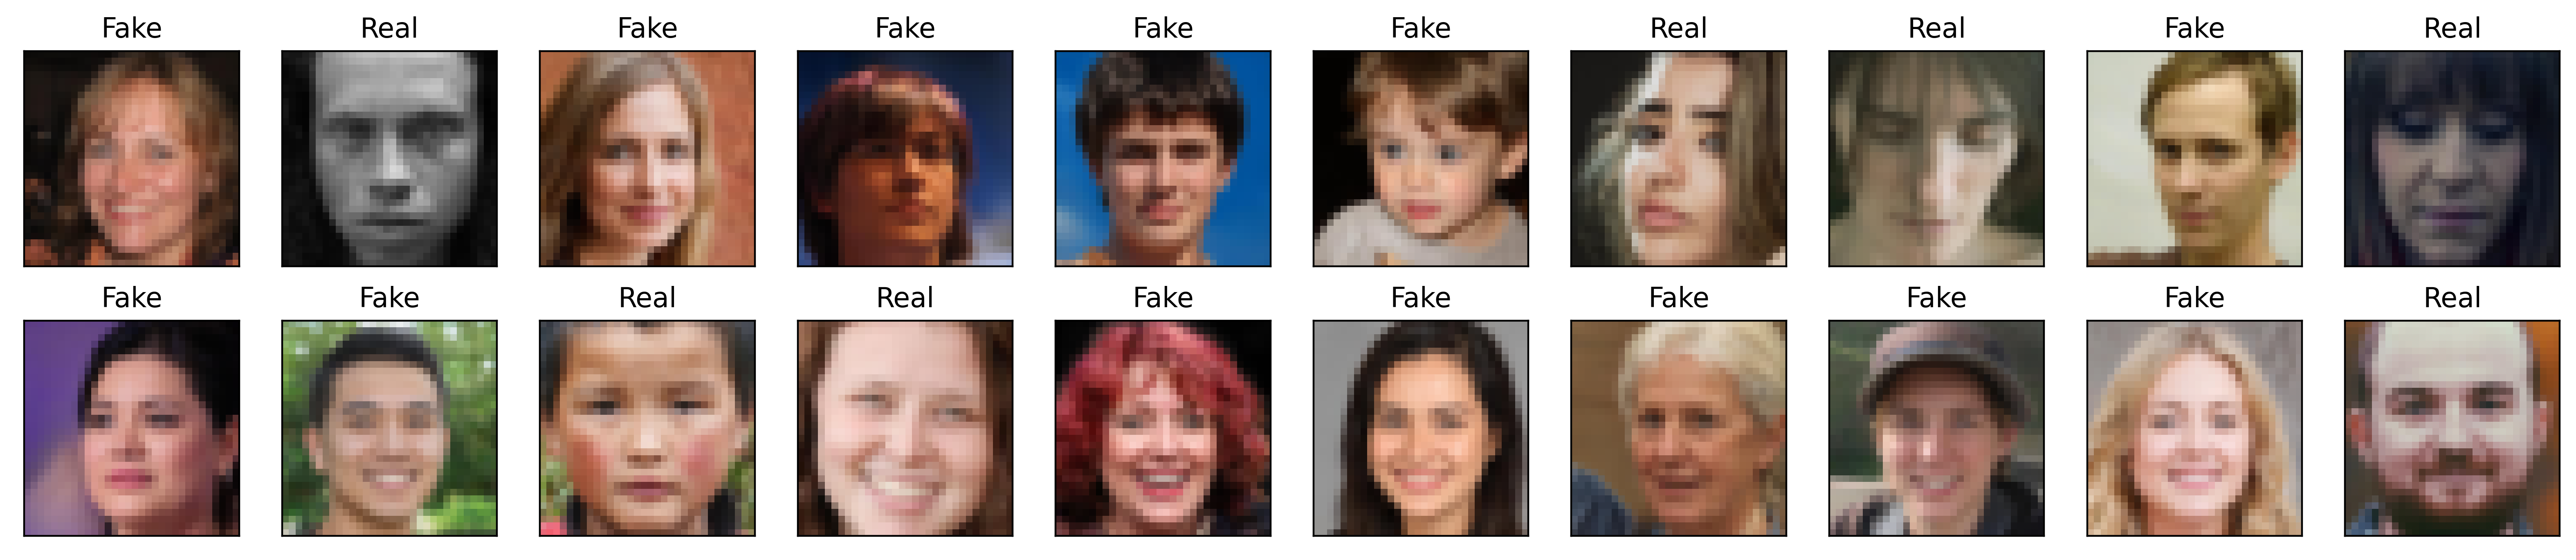

In [ ]:
#helper function to un-normalize and display an image
def imshow(img):
#     img = img / 2 + 0.5  # unnormalize if you added normalization in the transformation step
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

In [ ]:
class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out

class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3
        if bottleneck:
            nDenseBlocks //= 2

        nChannels = 2*growthRate
        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans1 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate

        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
        out = F.log_softmax(self.fc(out))
        return out

In [ ]:
model = DenseNet(growthRate=12, depth=100, reduction=0.5,
bottleneck=True, nClasses=2).cuda()
model = nn.DataParallel(model)

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
])

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# number of epochs to train the model
n_epochs = 40

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'DenseNet35656_gan-detector_Final.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 0.487700 	Validation Loss: 0.257782

Validation loss decreased (inf --> 0.257782).  Saving model ...
Epoch: 2 	Training Loss: 0.480693 	Validation Loss: 0.207602

Validation loss decreased (0.257782 --> 0.207602).  Saving model ...
Epoch: 3 	Training Loss: 0.475820 	Validation Loss: 0.208333
Epoch: 4 	Training Loss: 0.473202 	Validation Loss: 0.207333

Validation loss decreased (0.207602 --> 0.207333).  Saving model ...
Epoch: 5 	Training Loss: 0.469294 	Validation Loss: 0.205742

Validation loss decreased (0.207333 --> 0.205742).  Saving model ...
Epoch: 6 	Training Loss: 0.465631 	Validation Loss: 0.204404

Validation loss decreased (0.205742 --> 0.204404).  Saving model ...
Epoch: 7 	Training Loss: 0.463281 	Validation Loss: 0.202745

Validation loss decreased (0.204404 --> 0.202745).  Saving model ...
Epoch: 8 	Training Loss: 0.459299 	Validation Loss: 0.200644

Validation loss decreased (0.202745 --> 0.200644).  Saving model ...
Epoch: 9 	Training Loss: 0.

In [ ]:
model.eval()

model.load_state_dict(torch.load('/content/DenseNet35656_gan-detector_Final.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
#     print(target)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
#     print(output)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
#     print(pred)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
#         print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.566965

Test Accuracy of  Fake: 83% (10/12)
Test Accuracy of  Real: 64% ( 9/14)

Test Accuracy (Overall): 73% (19/26)


Text(0, 0.5, 'training vis')

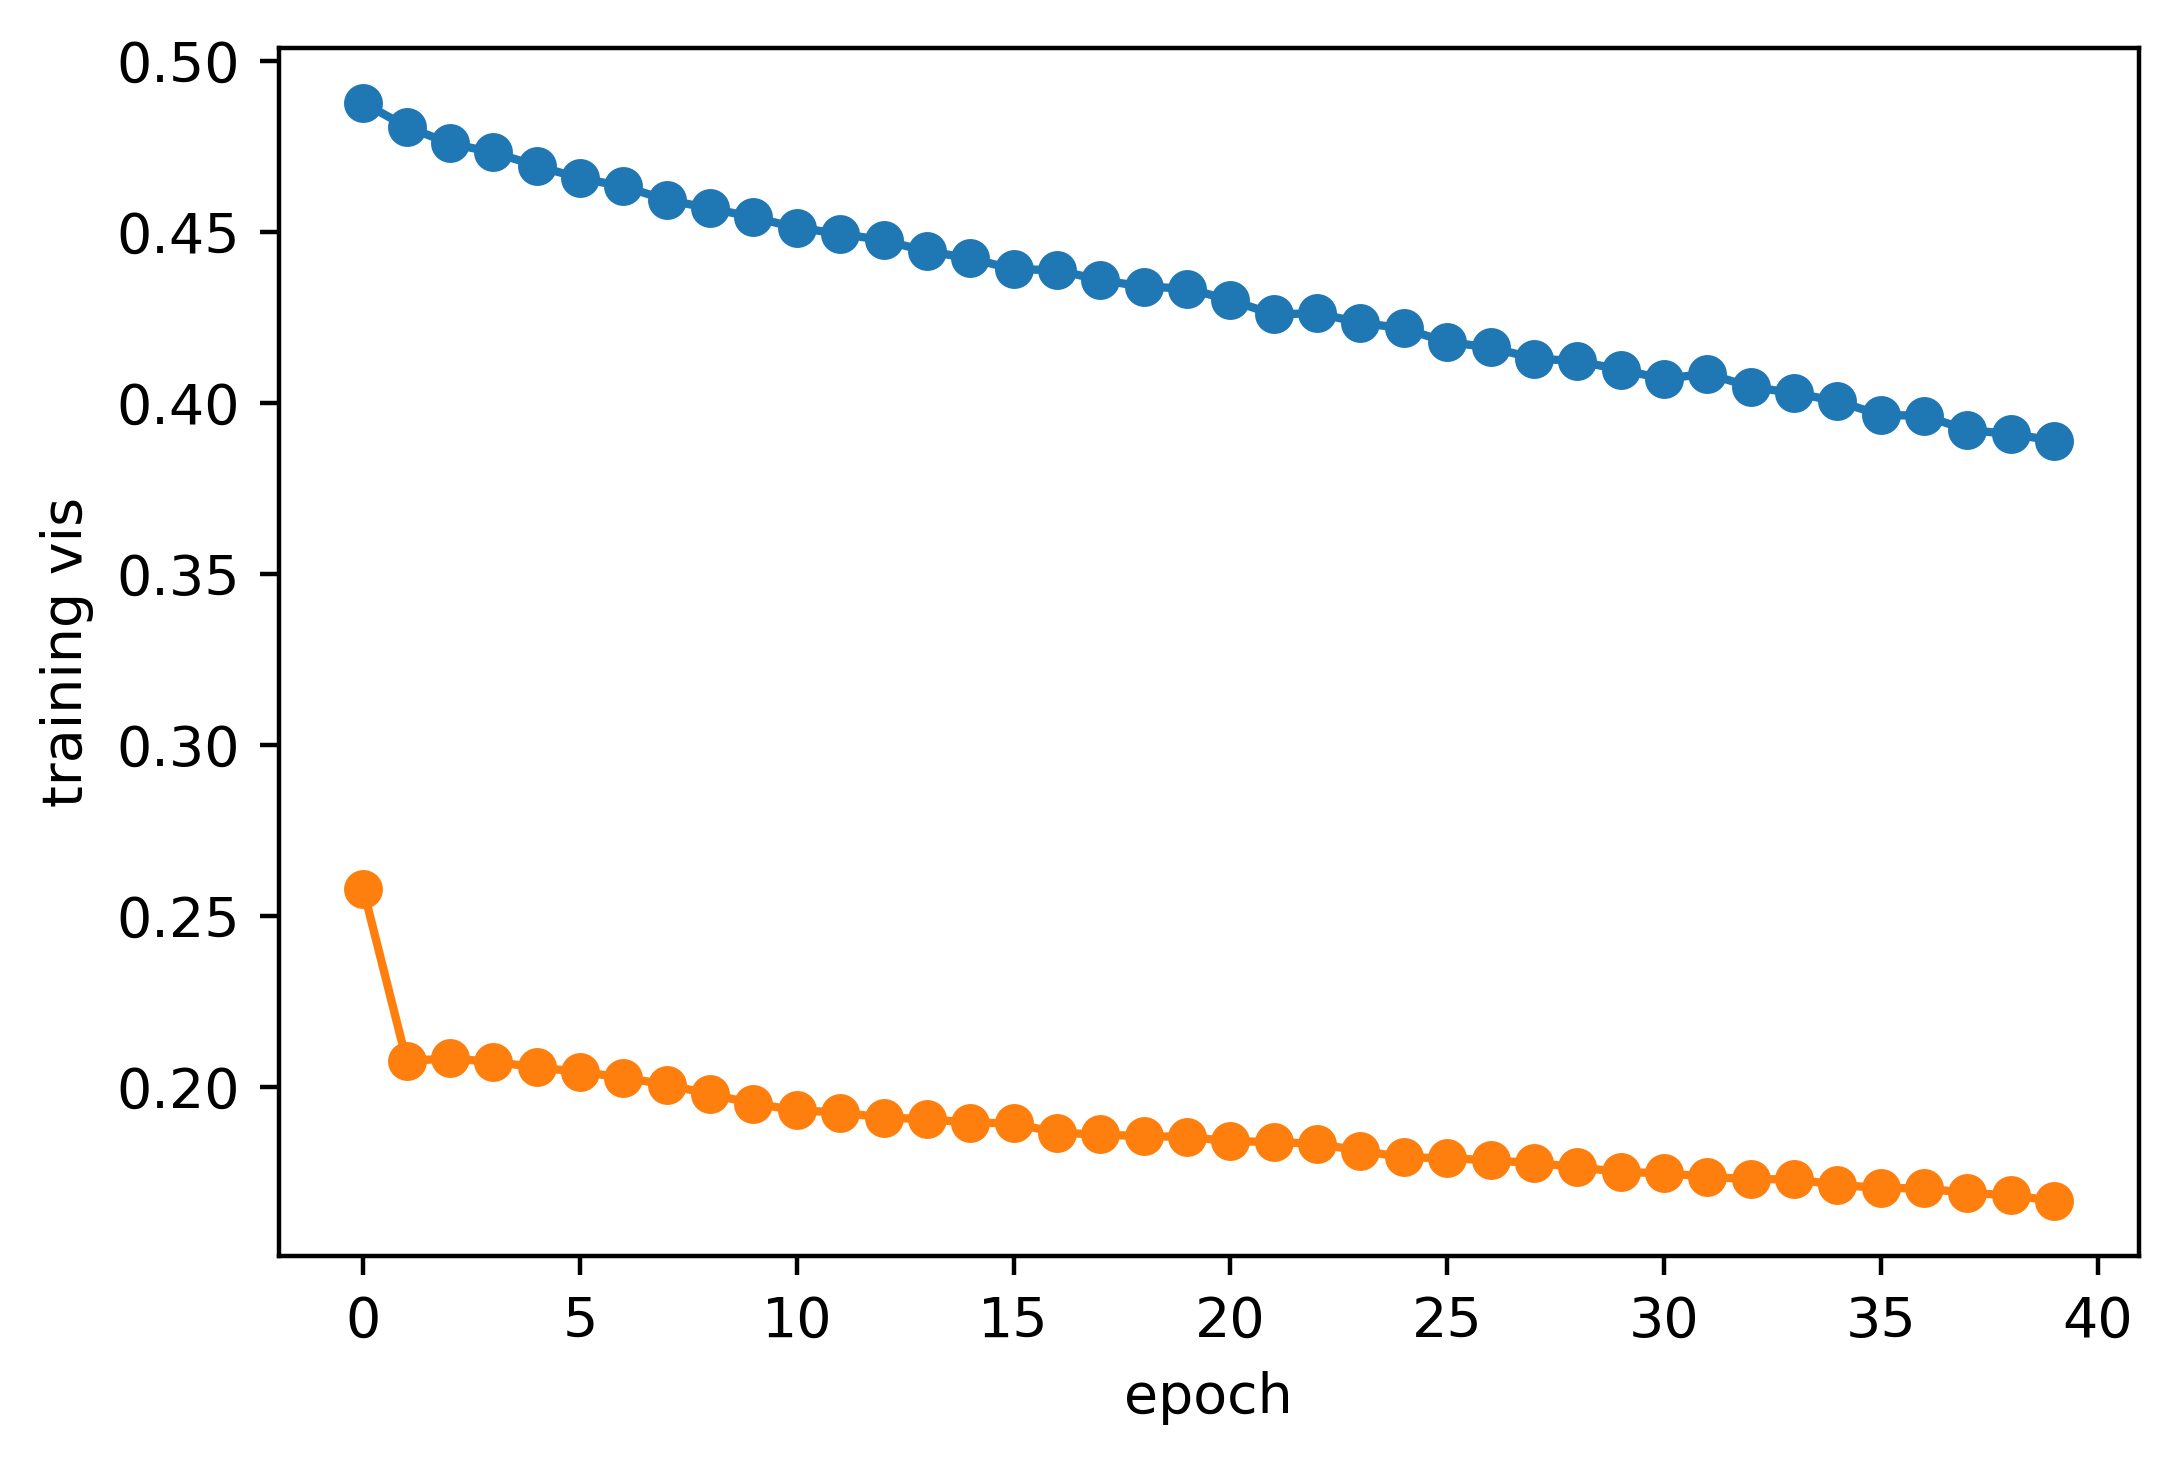

In [ ]:
plt.plot(range(epoch), training_vis)
plt.scatter(range(epoch), training_vis)
plt.scatter(range(epoch), valid_vis)
plt.plot(range(epoch), valid_vis)

plt.xlabel("epoch")
plt.ylabel("training vis")

 #np.savetxt('DenseNet.txt', [training_vis, valid_vis])
#plt.savefig()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(20, 3, 32, 32)


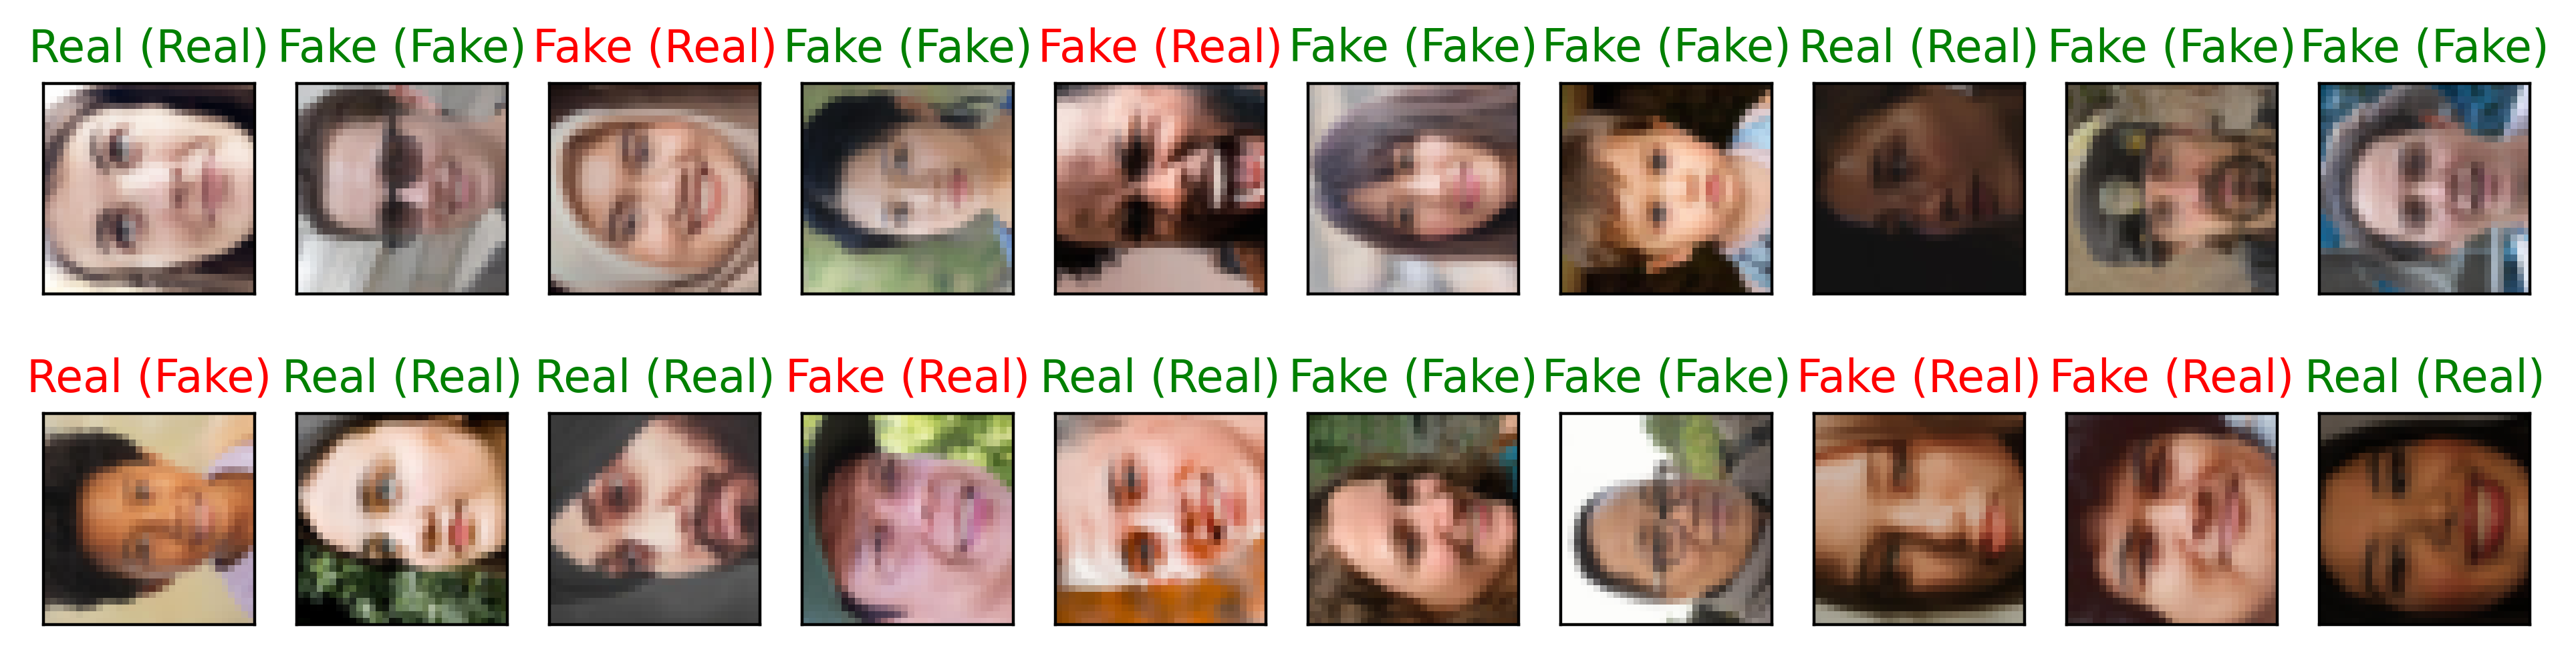

In [ ]:
# # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()
print(images.shape)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(12,3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.swapaxes((images[idx]),axis1=0, axis2=2))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))
plt.savefig('Densenet_misclass.pdf')

In [ ]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib

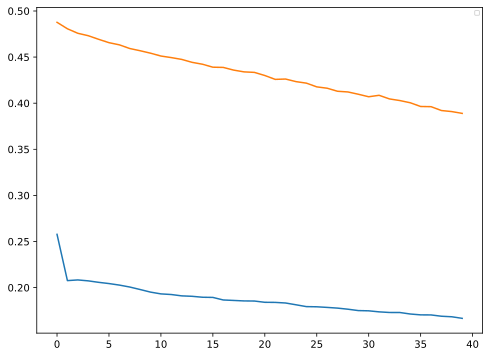

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6 
plt.plot(valid_vis)
plt.plot(training_vis)
plt.legend()